In [1]:
from skactiveml.base import SkactivemlClassifier
import warnings
import numpy as np

from skactiveml.utils import (
    MISSING_LABEL,
    is_labeled,
)

from skorch import NeuralNet
import torch
from torch import nn
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import transforms

import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings

from copy import deepcopy
from skactiveml.utils import call_func, unlabeled_indices
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
class SkorchClassifier(SkactivemlClassifier, NeuralNet):
    def __init__(
        self,
        module,
        *args,
        classes=None,
        missing_label=MISSING_LABEL,
        cost_matrix=None,
        random_state=None,
        criterion=nn.NLLLoss,
        **module_kwargs,
    ):
        SkactivemlClassifier.__init__(
            self,
            classes=classes,
            missing_label=missing_label,
            cost_matrix=cost_matrix,
            random_state=random_state,
        )
        
        NeuralNet.__init__(
            self,
            module,
            *args,
            criterion=criterion,
            **module_kwargs
        )

    def get_loss(self, y_pred, y_true, *args, **kwargs):
        pass

    def fit(self, X, y=None, **fit_params):
        # check input parameters

        # check whether model is a valid model

        is_lbld = is_labeled(y, missing_label=self.missing_label)
        print(is_lbld.shape)

In [3]:
MISSING_LABEL = -1
RANDOM_STATE = 0
FONTSIZE = 12

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

warnings.filterwarnings("ignore")

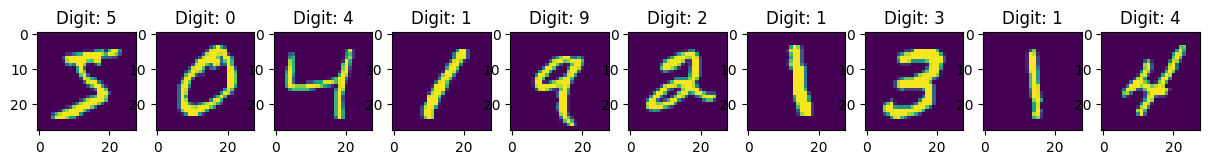

In [4]:
X, y_true = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

# Visualize first 10 images.
fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=10)
for i in range(10):
    axes[i].set_title(f'Digit: {y_true[i]}', fontsize=FONTSIZE)
    axes[i].imshow(X[i].reshape(28,28))
plt.show()

# Standardize data.
X = StandardScaler().fit_transform(X)

# Reshape samples to n_samples x n_channels x width x height to fit skorch
# requirements.
X = X.reshape((len(X), 1, 28, 28))

# Set data types according to skorch requirements.
X, y_true = X.astype(np.float32), y_true.astype(np.int64)

# Identify list of possible classes.
classes = np.unique(y_true)

# Make a 66-34 train-test split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y_true, train_size=0.66, random_state=RANDOM_STATE
)

In [5]:
transform = transforms.Compose(
    [
        transforms.RandomAffine(degrees=(-10, 10), translate=(0.05, 0.05), scale=(0.9, 1.1)),
        transforms.RandomPerspective(distortion_scale=0.2, p=1.0),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.01, 0.1)),
    ]
)

In [6]:
class ClassifierModule(nn.Module):
    def __init__(self, n_classes, dropout=0.5, transform=None):
        super(ClassifierModule, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, n_classes)
        self.fc1_drop = nn.Dropout(p=dropout)
        self.transform = transform or transforms.Compose([])

    def forward(self, x):
        if self.training:
            # Usually, transforms are part of the datasets.
            with torch.no_grad():
                x = self.transform(x)
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # flatten over channel, height and width = 1600
        x = x.view(x.size(0), -1)
        
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [7]:
net = SkorchClassifier(
    ClassifierModule,
    classes=classes,
    missing_label=MISSING_LABEL,
    max_epochs=100,
    batch_size=16,
    lr=0.01,
    verbose=False,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.9,
    optimizer__weight_decay=3e-3,
    train_split=False,
    device=device,
)

In [8]:
net.fit(X_train, y_train)

<class '__main__.SkorchClassifier'>[uninitialized](
  module=<class '__main__.ClassifierModule'>,
)